In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.decomposition import PCA as sklearnPCA

# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings("ignore")

# 1. Explore Dataset

In [4]:
!wget https://www2.macs.hw.ac.uk/~js2001/data.csv --no-check-certificate

--2022-11-13 21:36:57--  https://www2.macs.hw.ac.uk/~js2001/data.csv
Resolving www2.macs.hw.ac.uk (www2.macs.hw.ac.uk)... 137.195.15.99
Connecting to www2.macs.hw.ac.uk (www2.macs.hw.ac.uk)|137.195.15.99|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 125204 (122K) [text/csv]
Saving to: ‘data.csv.1’

data.csv.1          100%[===================>] 122.27K   407KB/s    in 0.3s    

2022-11-13 21:36:58 (407 KB/s) - ‘data.csv.1’ saved [125204/125204]



In [5]:
df = pd.read_csv('data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [8]:
wbcd = df.iloc[:,:-1]
print("This WBCD dataset is consisted of",wbcd.shape)

This WBCD dataset is consisted of (569, 32)


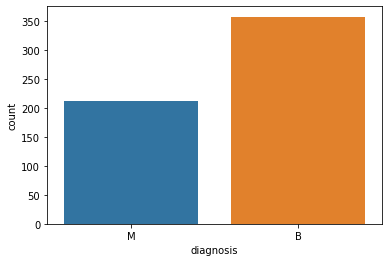

In [9]:
sns.countplot(wbcd['diagnosis'],label="Count")

## 1.2 Correlation Plot of 30 features

Text(0.5, 1.05, 'Correlation of our dataset Features')

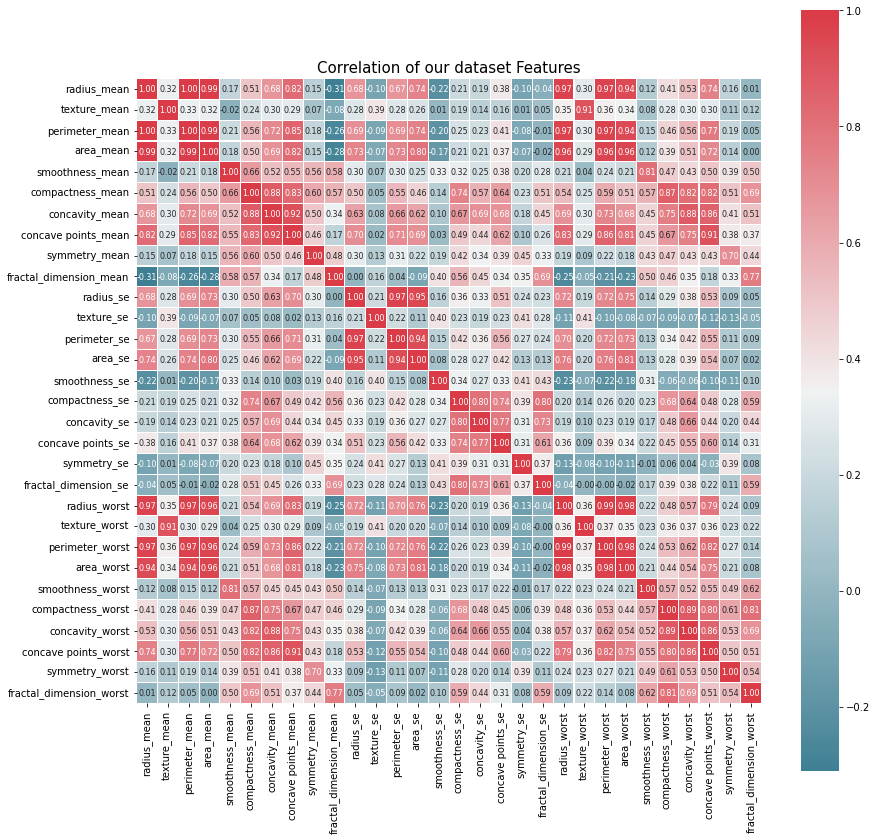

In [11]:
corr = wbcd.iloc[:,2:].corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 8},
            cmap = colormap, linewidths=0.1, linecolor='white')
plt.title('Correlation of our dataset Features', y=1.05, size=15)

## 1.3 *Divide* Our dataset into Train(70%) / Test data(30%)
Divide the data into two(train/test) to see the predictive power of the model.


In [12]:
train,test = train_test_split(wbcd, test_size=0.3, random_state=42)
print("Training Data :",train.shape)
print("Testing Data :",test.shape)

Training Data : (398, 32)
Testing Data : (171, 32)


In [13]:
train_id = train['id']
test_id = test['id']

train_data = train.iloc[:,1:]
test_data = test.iloc[:,1:]

print("Training Data :",train_data.shape)
print("Testing Data :",test_data.shape)

Training Data : (398, 31)
Testing Data : (171, 31)


Seperate x:Feature data(30) / y:Result data(1)
Seperate by **x_data, y_data**
* x_data : columns(features to predict **diagnosis**) for training. (eliminate diagnosis)
* y_data : columns for comparing with predictions results. (need original diagnosis)
Normalize x_data values for better prediction

In [14]:
# Training Data
train_x = train_data.iloc[:,1:]
train_x = MinMaxScaler().fit_transform(train_x)
print("Training Data :", train_x.shape)

# Testing Data
test_x = test_data.iloc[:,1:]
test_x = MinMaxScaler().fit_transform(test_x)
print("Testing Data :", test_x.shape)

Training Data : (398, 30)
Testing Data : (171, 30)


Change Results(diagnosis) format : String -> int

In [15]:
# Training Data
train_y = train_data.iloc[:,:1]
train_y[train_y=='M'] = 0
train_y[train_y=='B'] = 1
print("Training Data :", train_y.shape)

# Testing Data
test_y = test_data.iloc[:,:1]
test_y[test_y=='M'] = 0
test_y[test_y=='B'] = 1
print("Testing Data :", test_y.shape)

Training Data : (398, 1)
Testing Data : (171, 1)


# 2. Make ANN-SLP Model
Make "Placeholder" for dinamic variable allocation
Placeholder is one of the function in tensorflow.
It is a space to put and change values while the program is running.
* for X, a place must have 30 columns, since wbcd data has 30 features.
* for Y, a place must have 1 columns, since the results has 1 outcome.
* If you see the row "None", it means it has no size limits. (You can write -1 instead of "None")

In [19]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
X = tf.placeholder(tf.float32, [None,30])
Y = tf.placeholder(tf.float32, [None, 1])

Instructions for updating:
non-resource variables are not supported in the long term


Make Weight, Bias value with randomly
* W(weight) : why **[30,1]**?  16 for 16 features, 1 for 1 Outcome(results).
* P(weight): why **[10,1]**? 10 for 10 PCA features, 1 for 1 Outcome(results).
* b(bias) : why **[1]**?  outcome has 1 layers.

In [20]:
# weight
W = tf.Variable(tf.random_normal([30,1], seed=0), name='weight')

# bias
b = tf.Variable(tf.random_normal([1], seed=0), name='bias')

Make Output Results
 * **Output = Weight * Input + Bias**
 * tf.matmul() : for array multiply

In [21]:
logits = tf.matmul(X,W) + b

In [22]:
hypothesis = tf.nn.sigmoid(logits)

cost_i = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=Y)
cost = tf.reduce_mean(cost_i)
# cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) * tf.log(1 - hypothesis))

In [23]:
train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

Compare : original vs. prediction

In [24]:
prediction = tf.cast(hypothesis > 0.5, dtype=tf.float32)
correct_prediction = tf.equal(prediction, Y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

In [25]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(10001):
        sess.run(train, feed_dict={X: train_x, Y: train_y})
        if step % 1000 == 0:
            loss, acc = sess.run([cost, accuracy], feed_dict={X: train_x, Y: train_y})
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))
            
    train_acc = sess.run(accuracy, feed_dict={X: train_x, Y: train_y})
    test_acc,test_predict,test_correct = sess.run([accuracy,prediction,correct_prediction], feed_dict={X: test_x, Y: test_y})
    print("Model Prediction =", train_acc)
    print("Test Prediction =", test_acc)

Step:     0	Loss: 0.848	Acc: 39.70%
Step:  1000	Loss: 0.238	Acc: 91.21%
Step:  2000	Loss: 0.180	Acc: 94.72%
Step:  3000	Loss: 0.154	Acc: 96.23%
Step:  4000	Loss: 0.138	Acc: 96.98%
Step:  5000	Loss: 0.128	Acc: 97.49%
Step:  6000	Loss: 0.120	Acc: 97.74%
Step:  7000	Loss: 0.114	Acc: 97.99%
Step:  8000	Loss: 0.110	Acc: 98.24%
Step:  9000	Loss: 0.106	Acc: 98.24%
Step: 10000	Loss: 0.102	Acc: 98.24%
Model Prediction = 0.98241204
Test Prediction = 0.94736844


* train_x, test_x : normalization data
* 30 features
* train_y, test_y

In [26]:
def ann_slp():
    print("===========Data Summary===========")
    print("Training Data :", train_x.shape)
    print("Testing Data :", test_x.shape)

    X = tf.placeholder(tf.float32, [None,30])
    Y = tf.placeholder(tf.float32, [None, 1])

    W = tf.Variable(tf.random_normal([30,1], seed=0), name='weight')
    b = tf.Variable(tf.random_normal([1], seed=0), name='bias')

    logits = tf.matmul(X,W) + b
    hypothesis = tf.nn.sigmoid(logits)
    
    cost_i = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=Y)
    cost = tf.reduce_mean(cost_i)

    train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

    prediction = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    correct_prediction = tf.equal(prediction, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

    print("\n============Processing============")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(10001):
            sess.run(train, feed_dict={X: train_x, Y: train_y})
            if step % 1000 == 0:
                loss, acc = sess.run([cost, accuracy], feed_dict={X: train_x, Y: train_y})
                print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))

        train_acc = sess.run(accuracy, feed_dict={X: train_x, Y: train_y})
        test_acc,test_predict,test_correct = sess.run([accuracy,prediction,correct_prediction], feed_dict={X: test_x, Y: test_y})
        
        print("\n============Results============")
        print("Model Prediction =", train_acc)
        print("Test Prediction =", test_acc)
        
        return train_acc,test_acc
    
ann_slp_train_acc, ann_slp_test_acc = ann_slp()

===========Data Summary===========
Training Data : (398, 30)
Testing Data : (171, 30)

============Processing============
Step:     0	Loss: 0.848	Acc: 39.70%
Step:  1000	Loss: 0.238	Acc: 91.21%
Step:  2000	Loss: 0.180	Acc: 94.72%
Step:  3000	Loss: 0.154	Acc: 96.23%
Step:  4000	Loss: 0.138	Acc: 96.98%
Step:  5000	Loss: 0.128	Acc: 97.49%
Step:  6000	Loss: 0.120	Acc: 97.74%
Step:  7000	Loss: 0.114	Acc: 97.99%
Step:  8000	Loss: 0.110	Acc: 98.24%
Step:  9000	Loss: 0.106	Acc: 98.24%
Step: 10000	Loss: 0.102	Acc: 98.24%

============Results============
Model Prediction = 0.98241204
Test Prediction = 0.94736844


* pca_train_x, pca_test_x : normalization, PCA
* 30 -> 10 features
* train_y, test_y : we can use the same data as above activation values, since there are no changes in y_data

In [27]:
def ann_slp_pca():
    sklearn_pca = sklearnPCA(n_components=10)

    print("===========Data Summary===========")
    pca_train_x = sklearn_pca.fit_transform(train_x)
    print("PCA Training Data :", pca_train_x.shape)

    pca_test_x = sklearn_pca.fit_transform(test_x)
    print("PCA Testing Data :", pca_test_x.shape)

    X = tf.placeholder(tf.float32, [None,10])
    Y = tf.placeholder(tf.float32, [None, 1])

    W = tf.Variable(tf.random_normal([10,1], seed=0), name='weight')
    b = tf.Variable(tf.random_normal([1], seed=0), name='bias')

    logits = tf.matmul(X,W) + b
    hypothesis = tf.nn.sigmoid(logits)

    cost_i = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=Y)
    cost = tf.reduce_mean(cost_i)

    train = tf.train.GradientDescentOptimizer(learning_rate=0.2).minimize(cost)

    prediction = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    correct_prediction = tf.equal(prediction, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

    print("\n============Processing============")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(10001):
            sess.run(train, feed_dict={X: pca_train_x, Y: train_y})
            if step % 1000 == 0:
                loss, acc = sess.run([cost, accuracy], feed_dict={X: pca_train_x, Y: train_y})
                print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))

        train_acc = sess.run(accuracy, feed_dict={X: pca_train_x, Y: train_y})
        test_acc,test_predict,test_correct = sess.run([accuracy,prediction,correct_prediction], feed_dict={X: pca_test_x, Y: test_y})
        
        print("\n============Results============")
        print("PCA Model Prediction =", train_acc)
        print("PCA Test Prediction =", test_acc)
        
        return train_acc, test_acc
    
ann_slp_pca_train_acc, ann_slp_pca_test_acc = ann_slp_pca()

===========Data Summary===========
PCA Training Data : (398, 10)
PCA Testing Data : (171, 10)

============Processing============
Step:     0	Loss: 0.701	Acc: 54.52%
Step:  1000	Loss: 0.142	Acc: 96.23%
Step:  2000	Loss: 0.117	Acc: 96.98%
Step:  3000	Loss: 0.106	Acc: 97.49%
Step:  4000	Loss: 0.100	Acc: 97.74%
Step:  5000	Loss: 0.095	Acc: 97.74%
Step:  6000	Loss: 0.092	Acc: 97.74%
Step:  7000	Loss: 0.089	Acc: 97.74%
Step:  8000	Loss: 0.087	Acc: 97.99%
Step:  9000	Loss: 0.086	Acc: 97.99%
Step: 10000	Loss: 0.084	Acc: 97.99%

============Results============
PCA Model Prediction = 0.9798995
PCA Test Prediction = 0.9649123


* train_x, test_x : normalization data
* 30 features
* train_y, test_y

In [28]:
def ann_mlp():
    print("===========Data Summary===========")
    print("Training Data :", train_x.shape)
    print("Testing Data :", test_x.shape)

    X = tf.placeholder(tf.float32, [None,30])
    Y = tf.placeholder(tf.float32, [None, 1])

    # input
    W1 = tf.Variable(tf.random_normal([30,60], seed=0), name='weight1')
    b1 = tf.Variable(tf.random_normal([60], seed=0), name='bias1')
    layer1 = tf.nn.sigmoid(tf.matmul(X,W1) + b1)

    # hidden1
    W2 = tf.Variable(tf.random_normal([60,60], seed=0), name='weight2')
    b2 = tf.Variable(tf.random_normal([60], seed=0), name='bias2')
    layer2 = tf.nn.sigmoid(tf.matmul(layer1,W2) + b2)

    # hidden2
    W3 = tf.Variable(tf.random_normal([60,90], seed=0), name='weight3')
    b3 = tf.Variable(tf.random_normal([90], seed=0), name='bias3')
    layer3 = tf.nn.sigmoid(tf.matmul(layer2,W3) + b3)

    # output
    W4 = tf.Variable(tf.random_normal([90,1], seed=0), name='weight4')
    b4 = tf.Variable(tf.random_normal([1], seed=0), name='bias4')
    logits = tf.matmul(layer3,W4) + b4
    hypothesis = tf.nn.sigmoid(logits)

    cost_i = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=Y)
    cost = tf.reduce_mean(cost_i)

    train = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(cost)

    prediction = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    correct_prediction = tf.equal(prediction, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

    print("\n============Processing============")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(10001):
            sess.run(train, feed_dict={X: train_x, Y: train_y})
            if step % 1000 == 0:
                loss, acc = sess.run([cost, accuracy], feed_dict={X: train_x, Y: train_y})
                print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))

        train_acc = sess.run(accuracy, feed_dict={X: train_x, Y: train_y})
        test_acc,test_predict,test_correct = sess.run([accuracy,prediction,correct_prediction], feed_dict={X: test_x, Y: test_y})
        
        print("\n============Results============")
        print("Model Prediction =", train_acc)
        print("Test Prediction =", test_acc)
        
        return train_acc,test_acc
    
ann_mlp_train_acc, ann_mlp_test_acc = ann_mlp()

===========Data Summary===========
Training Data : (398, 30)
Testing Data : (171, 30)

============Processing============
Step:     0	Loss: 2.073	Acc: 37.44%
Step:  1000	Loss: 0.335	Acc: 89.95%
Step:  2000	Loss: 0.266	Acc: 92.71%
Step:  3000	Loss: 0.226	Acc: 93.72%
Step:  4000	Loss: 0.199	Acc: 93.97%
Step:  5000	Loss: 0.180	Acc: 95.23%
Step:  6000	Loss: 0.166	Acc: 95.98%
Step:  7000	Loss: 0.155	Acc: 96.23%
Step:  8000	Loss: 0.147	Acc: 96.73%
Step:  9000	Loss: 0.139	Acc: 96.98%
Step: 10000	Loss: 0.133	Acc: 96.98%

============Results============
Model Prediction = 0.9698492
Test Prediction = 0.9298246


* pca_train_x, pca_test_x : normalization, PCA
* 30 -> 10 features
* train_y, test_y : we can use the same data as above activation values, since there are no changes in y_data

In [29]:
def ann_mlp_pca():
    sklearn_pca = sklearnPCA(n_components=10)

    print("===========Data Summary===========")
    pca_train_x = sklearn_pca.fit_transform(train_x)
    print("PCA Training Data :", pca_train_x.shape)

    pca_test_x = sklearn_pca.fit_transform(test_x)
    print("PCA Testing Data :", pca_test_x.shape)

    X = tf.placeholder(tf.float32, [None,10])
    Y = tf.placeholder(tf.float32, [None, 1])

    # input
    W1 = tf.Variable(tf.random_normal([10,64], seed=0), name='weight1')
    b1 = tf.Variable(tf.random_normal([64], seed=0), name='bias1')
    layer1 = tf.nn.sigmoid(tf.matmul(X,W1) + b1)

    # hidden1
    W2 = tf.Variable(tf.random_normal([64,128], seed=0), name='weight2')
    b2 = tf.Variable(tf.random_normal([128], seed=0), name='bias2')
    layer2 = tf.nn.sigmoid(tf.matmul(layer1,W2) + b2)

    # hidden2
    W3 = tf.Variable(tf.random_normal([128,128], seed=0), name='weight3')
    b3 = tf.Variable(tf.random_normal([128], seed=0), name='bias3')
    layer3 = tf.nn.sigmoid(tf.matmul(layer2,W3) + b3)

    # output
    W4 = tf.Variable(tf.random_normal([128,1], seed=0), name='weight4')
    b4 = tf.Variable(tf.random_normal([1], seed=0), name='bias4')
    logits = tf.matmul(layer3,W4) + b4
    hypothesis = tf.nn.sigmoid(logits)

    cost_i = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=Y)
    cost = tf.reduce_mean(cost_i)

    train = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)

    prediction = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    correct_prediction = tf.equal(prediction, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

    print("\n============Processing============")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(10001):
            sess.run(train, feed_dict={X: pca_train_x, Y: train_y})
            if step % 1000 == 0:
                loss, acc = sess.run([cost, accuracy], feed_dict={X: pca_train_x, Y: train_y})
                print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))

        train_acc = sess.run(accuracy, feed_dict={X: pca_train_x, Y: train_y})
        test_acc,test_predict,test_correct = sess.run([accuracy,prediction,correct_prediction], feed_dict={X: pca_test_x, Y: test_y})
        
        print("\n============Results============")
        print("PCA Model Prediction =", train_acc)
        print("PCA Test Prediction =", test_acc)
        
        return train_acc,test_acc
        
ann_mlp_pca_train_acc, ann_mlp_pca_test_acc = ann_mlp_pca()

===========Data Summary===========
PCA Training Data : (398, 10)
PCA Testing Data : (171, 10)

============Processing============
Step:     0	Loss: 2.958	Acc: 62.56%
Step:  1000	Loss: 0.109	Acc: 97.74%
Step:  2000	Loss: 0.086	Acc: 98.24%
Step:  3000	Loss: 0.075	Acc: 98.24%
Step:  4000	Loss: 0.068	Acc: 98.49%
Step:  5000	Loss: 0.063	Acc: 98.74%
Step:  6000	Loss: 0.059	Acc: 98.99%
Step:  7000	Loss: 0.055	Acc: 98.99%
Step:  8000	Loss: 0.053	Acc: 98.99%
Step:  9000	Loss: 0.051	Acc: 98.99%
Step: 10000	Loss: 0.049	Acc: 98.99%

============Results============
PCA Model Prediction = 0.98994976
PCA Test Prediction = 0.9532164


# 3. ANN Results

In [30]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['Predict_Type'] = test_predict.astype(int)
sub['Origin_Type'] = test_y
sub['Correct'] = test_correct
sub.head(10)

,id,Predict_Type,Origin_Type,Correct
204,87930,1,1,True
70,859575,0,0,True
131,8670,0,0,True
431,907915,1,1,True
540,921385,1,1,True
567,927241,0,0,True
369,9012000,0,0,True
29,853201,0,0,True
81,8611161,0,1,False
477,911673,1,1,True
